# Initialization

In [1]:
import sys
import os.path
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
import seaborn as sns

#os.chdir("C:\\GitHub\\stimulator_calibration")
import scripts.stimulator_calibration_lib as scl
import scripts.simple_ai_recorder as sir

%matplotlib inline 

txtFileNewLineStr = "\r\n"

# Definitions
### General constants

In [2]:
h        = 4.135667E-15 # Planck's constant [eV*s]
c        = 299792458    # speed of light [m/s]
eV_per_J = 6.242E+18    # [eV] per [J]

### Photoreceptor- and species specific constants

*   `ac_um2`<br />
    Cone OS light collection area in [µm^2], see [Nikonov et al., 2006](http://www.ncbi.nlm.nih.gov/pubmed/16567464) for details. This is an experimentally determined value, e.g. for wt mouse cones that is fully dark-adapted, a value of 0.2 can be assumed.
*   `ar_um2`<br />
    Rod OS light collection area, see above. A value of 0.5 is realistic.   


In [3]:
ac_um2 = 0.2     
ar_um2 = 0.5

### Relative path to data files

In [4]:
pathData = "C:\\Users\\eulerlab\\Documents\\stimulator_calibration_setup2\\data\\"

### Photoreceptors
Load opsin spectra from text files in the data folder defined above:
* Text files are expected to have one column per opsin ... 
* ... plus one (the last one) for the scaling in x direction (wavelength, in 1-nm increments).
* All spectral files, including the filter and LED files loaded later, must have the same x range. In this version, 300 .. 699 nm is used.

In [5]:
x_wavelen_nm = np.loadtxt(pathData +"mouse_cone_opsins.txt", usecols=(2,)) # 300 .. 699 nm
mouseMOpsin  = np.loadtxt(pathData +"mouse_cone_opsins.txt", usecols=(1,))
mouseSOpsin  = np.loadtxt(pathData +"mouse_cone_opsins.txt", usecols=(0,))

Define photoreceptors as a list of dictionaries, with:

*   `name`, name of photoreceptor, used later for plots etc.
*   `peak_nm`, peak wavelength of opsin spectrum in [nm]          
*   `collecArea_um2`, see above
*   `spect`, opsin spectrum

In [6]:
MCone = {"name"           : "mouse_M_cone",
         "peak_nm"        : 511,
         "collecArea_um2" : ac_um2, 
         "spect"          : mouseMOpsin}
SCone = {"name"           : "mouse_S_cone",
         "peak_nm"        : 360,         
         "collecArea_um2" : ac_um2, 
         "spect"          : mouseSOpsin}
Rod   = {"name"           : "mouse_rod",
         "peak_nm"        : 510,         
         "collecArea_um2" : ar_um2, 
         "spect"          : []}

PRs   = [MCone, SCone, Rod]

### Stimulus LEDs and filters

Load spectra of LEDs, LED filter(s) and any other dicroics from text files; the format is expected to be the same as for the opsin spectra (see above), that is the same scaling in x (i.e. 300-699 nm, in 1-nm increments).

In [7]:
# LED spectra
#
LED_UV_name        = "LED_UV_404"
LED_UV             = np.loadtxt(pathData +LED_UV_name +".txt", usecols=(0,))

LED_Green_name     = "LED_Green_590"
LED_Green          = np.loadtxt(pathData +LED_Green_name +".txt", usecols=(0,))

# LED filter(s)
# (here, one two-band-pass filter is used instead of one for each LED)
#
Dichr_UV_name = "F39-404"
Dichr_UV      = np.loadtxt(pathData +Dichr_UV_name +".txt", usecols=(0,))

Dichr_Green_name = "F37-576"
Dichr_Green      = np.loadtxt(pathData +Dichr_Green_name +".txt", usecols=(0,))

# Dicroic above the objective lens in the MOM
# (if not used, comment line that loads text file and uncomment next line)
#
Dichr_Obj_name     = "F73-063_z400-580-890"
Dichr_Obj          = np.loadtxt(pathData +Dichr_Obj_name +".txt", usecols=(0,))
#Dichr_Obj         = np.array(list([1.0]*len(LED_UV)))

Define stimulus LED/filter combinations as a list of dictionaries, with:

*   `name`, name of LED/filter combinations, used later for plots etc.
*   `peak_nm`, peak wavelength of LED/filter combination in [nm]          
*   `bandwidth_nm`, LED/filter band width in [nm]. If 0 then the LED's spectrum is expected to be contained in `LED_spect` (same x range as the opsin spectra, see above, and with 1-nm resolution). Otherwise, the spectrum `spect` will be calculated, also acknowledging the filter `filter_spect`, if defined.
*   `LED_spect`, spectrum of LED
*   `filter_spect`, spectrum of filter
*   `spect`, resulting spectrum, will be calculated
*   `pow_meas_nW[]`, series of power measurements for this LED, in [nW], at the LED levels given in `levels` (0..255). These values will be filled out in the next step below.
*   `levels`, see above

In [8]:
# Example, where the LED/filter spectrum is calculated from the peak and 
# the width of a narrow filter (as, e.g. in setup 2)
#
"""
GrLED = {"name"         : "green",
         "peak_nm"      : 578,
         "bandwidth_nm" : 10,
         "LED_spect"    : [],
         "filter_spect" : [],
         "spect"        : [],
         "pow_meas_nW"  : GrLED_pow,
         "levels"       : GrLED_lev}
BlLED = {"name"         : "blue",
         "peak_nm"      : 400,
         "bandwidth_nm" : 20,
         "LED_spect"    : [],
         "filter_spect" : [],
         "spect"        : [],
         "pow_meas_nW"  : BlLED_pow,
         "levels"       : BlLED_lev}
"""

# Example, where the spectrum of the LED/filter combination is calculated 
# from the LED spectrum and the filter spectrum (e.g. for the new LCr 
# two-band filter stimulator, setup 3)
#
GrLED = {"name"         : "green",
         "peak_nm"      : 575,
         "bandwidth_nm" : 10,
         "LED_spect"    : LED_Green,
         "filter_spect" : Dichr_Green, 
         "spect"        : [], 
         "pow_meas_nW"  : [], 
         "levels"       : []}
UVLED = {"name"         : "UV",
         "peak_nm"      : 404,
         "bandwidth_nm" : 10,
         "LED_spect"    : LED_UV,
         "filter_spect" : Dichr_UV,
         "spect"        : [], 
         "pow_meas_nW"  : [],
         "levels"       : []}

LEDs  = [GrLED, UVLED]

# Read calibration data

### Definitions

Measure the power for a series of light levels applied to the different LEDs in sequence. An Arduino with the SimpleAIRecorder firmware has to be connected (`comPortName`), the duration of one measurement sequence (`dur_s`) and a file name for the recorded data (`calFileName`) has to be defined. 

* `startLevel`, `stepLevel` and `nLevels`define the sequence of intensities (0..255) that is recorded. Alternatively, also the complete sequence can be given in `Levels`.

* `nW_per_V` gives the correction factor to convert the reading in [V] from the powermeter's analog connector (the "speaker" socket) into [nW].

* If file named `calFileName*` (*=the name of an LED) already exist, they will be loaded instead of starting the recording.

* `r_spot_mm` is the diameter of stimulus spot on the detector

In [184]:
# User definitions
#
comPortName   = "COM3"
comPortBaud   = 115200
calFileName   = "2017-08-30_calib_019"
gammaFileName = "defaultGammaLUT.txt"
gammaLEDOrder = ["UV", "green", ""]

dur_s        = 113.0
startLevel   = 0
stepLevel    = 5
nLevels      = 256//stepLevel
maxLevel     = 255
Levels       = list(range(startLevel,maxLevel+1, stepLevel))

nW_per_V     = 272.0  # Assuming the Arduino analog-in uses the internal 1.1 V reference
r_spot_mm    = 0.250

### Run calibration measurement

... or read data from file, if one exists that is named ``calFileName``

Illuminated area is 1.963 mm2
Prepare to measure LED `green` and press Enter to continue...
Opened serial port COM3 at 115200 baud
Sampling rate is 5.001 ms
113.000 s duration = 22596 samples
100% done                                        
SUCCESS
22596 data points recorded
Rate = 5.000 +/- 0.001 ms
Closed serial port COM3
Prepare to measure LED `UV` and press Enter to continue...
Opened serial port COM3 at 115200 baud
Sampling rate is 5.001 ms
113.000 s duration = 22596 samples
100% done                                        
SUCCESS
22596 data points recorded
Rate = 5.000 +/- 0.001 ms
Closed serial port COM3


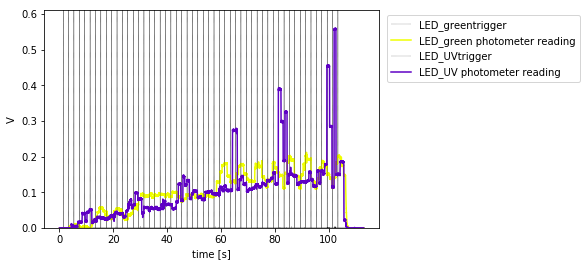

In [185]:
# Calculate area of spot on the detector
#
A_detect_um2 = np.pi *(r_spot_mm *1E3)**2
print("Illuminated area is {0:.3f} mm2".format(A_detect_um2 *10e-6))

# Initialize 
#
LEDs_meas_t = []
LEDs_meas_0 = []
LEDs_meas_1 = []
fh = plt.figure()
ax=fh.add_subplot(111)

for i, LED in enumerate(LEDs):
    if not(os.path.isfile(pathData +calFileName +LED["name"] +".txt")):
        # Calibration data file does not exist, therefore read data from Arduino 
        # running the simple recorder firmware (SimpleAIRecorder2)
        #
        input("Prepare to measure LED `{0}` and press Enter to continue...".format(LED["name"]))
        SRec = sir.SimpleAIRecorder()
        SRec.openLink(comPortName, comPortBaud)
        (errC, data_t, data_0, data_1) = SRec.readData(duration_s=dur_s, toV=True, maxV=1.1)
        SRec.closeLink()
        LEDs_meas_t.append(data_t)
        LEDs_meas_0.append(data_0)
        LEDs_meas_1.append(data_1)
        np.savetxt(pathData +calFileName +LED["name"] +".txt", np.transpose([data_t, data_0, data_1]),
                   header="time\tAI0\tAI1", newline=txtFileNewLineStr)
    
    else:    
        # Load calibration data file(s)
        #
        LEDs_meas_t.append(np.
                           loadtxt(pathData +calFileName +LED["name"] +".txt", usecols=(0,)))
        LEDs_meas_0.append(np.loadtxt(pathData +calFileName +LED["name"] +".txt", usecols=(1,)))
        LEDs_meas_1.append(np.loadtxt(pathData +calFileName +LED["name"] +".txt", usecols=(2,)))
 
    # Plot data
    #
    colLED = scl.wavelength_to_rgb(LED["peak_nm"])
    #ax=fh.add_subplot(211)
    plt.plot(LEDs_meas_t[i], LEDs_meas_0[i], color="k", label="LED_" +LED["name"] + "trigger",linestyle="--",linewidth=0.2)
    #bx=fh.add_subplot(221)
    plt.plot(LEDs_meas_t[i], LEDs_meas_1[i], color=colLED, label="LED_" +LED["name"] +" photometer reading")
        
#ax[0].set_label(["time [s]", "V"])
ax.set_xlabel("time [s]")
ax.set_ylabel("V")
ax.set_ylim([0,np.max(LEDs_meas_1)+0.05])
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

### Process calibration data

Find triggers and average reading for each presentation that follows a trigger.

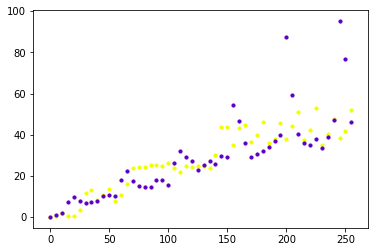

In [186]:
LEDs_meas_avg = []
LEDs_meas_std = []

for i, LED in enumerate(LEDs):
    # Find triggers and average trials
    #
    (trigTimes_s, trigIndices) = sir.findTriggers(LEDs_meas_t[i], LEDs_meas_0[i], 0.5)
    (data_avg, data_std)       = sir.averageTrialsByTriggers(trigIndices, LEDs_meas_1[i])
    LEDs_meas_avg.append(data_avg)
    LEDs_meas_std.append(data_std)

    # Complete the LED/stimulator combinations dictionaries with
    # the measurements
    #
    LED["pow_meas_nW"] = np.array(LEDs_meas_avg[i]) *nW_per_V
    LED["levels"]      = np.array(Levels)

    # Plot averages with standard deviation
    #
    colLED = scl.wavelength_to_rgb(LED["peak_nm"])
    plt.scatter(LED["levels"], LED["pow_meas_nW"][0:len(LED["levels"])], marker="o", s=10, color=colLED)
    #plt.errorbar(LED["levels"], LED["pow_meas_nW"], yerr=data_std, capsize=0, ls=None, \
    #             color=colLED, elinewidth=2)

# Determine effective photoreceptor stimulation

### Calculate spectra for effective LED/filter combinations 

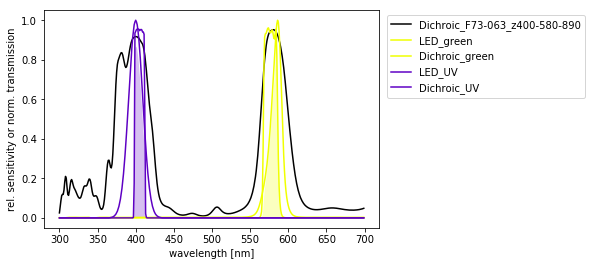

In [187]:
# Handle photoreceptor, dichroic and LED spectra ...
#
# Determin minimum and maximum wavelength of the given opsin spectra for
# the generation of the respective LED/filter spectra, assuming a spectral
# resolution of 1 nm
#
spectWidth  = len(x_wavelen_nm)
spectMin_nm = x_wavelen_nm[0]
spectMax_nm = x_wavelen_nm[spectWidth -1]

# If LED/filter spectra are not define, generate those from center 
# wavelength and band-pass width
#
fh = plt.figure()
ax= fh.add_subplot(111)
for LED in LEDs:
    if len(LED["LED_spect"]) == 0:
        # Generate a combined LED/bandpass filter spectrum
        #
        temp = []
        x1   = LED["peak_nm"] -LED["bandwidth_nm"]/2.0
        x2   = LED["peak_nm"] +LED["bandwidth_nm"]/2.0
        for i in range(spectWidth):
            temp.append(int(((i +spectMin_nm) > x1) and ((i +spectMin_nm) < x2)))
        LED["spect"] = np.array(temp)
        
    # Normalize the LED spectra
    #
    LED["LED_spect"] /= np.amax(LED["LED_spect"])
        
    # Calculate overlap of the spectra for LED, bandpass filter and objective dichroic;
    #
    LED["spect"]      = LED["LED_spect"] *LED["filter_spect"] *Dichr_Obj
    
    
# Plot spectra overview
#
plt.plot(x_wavelen_nm, Dichr_Obj, color="black", label="Dichroic_" +Dichr_Obj_name)

for LED in LEDs:        
    if len(LED["spect"]) > 0:    
        colLED = scl.wavelength_to_rgb(LED["peak_nm"])
        plt.plot(x_wavelen_nm, LED["LED_spect"], color=colLED, label="LED_" +LED["name"])
        if len(LED["filter_spect"]) > 0:    
            plt.plot(x_wavelen_nm, LED["filter_spect"], color=colLED, label="Dichroic_" +LED["name"])
        plt.fill(x_wavelen_nm, LED["spect"], facecolor=colLED, alpha=0.25)    


ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("rel. sensitivity or norm. transmission")

plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")    

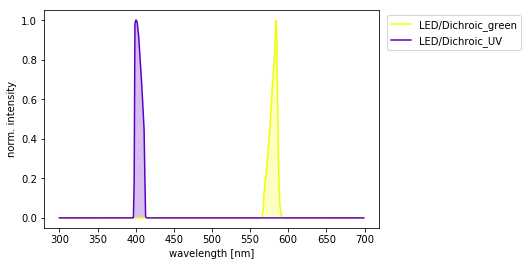

In [188]:
# Normalize the spectra of the LED/dichroic combinations
#
fh=plt.figure()
ax=fh.add_subplot(111)
for LED in LEDs:        
    if len(LED["spect"]) > 0:    
        # Normalize 
        #
        ymax          = np.amax(LED["spect"])
        LED["spect"] /= ymax
        
        # Plot spectra ...
        #
        colLED = scl.wavelength_to_rgb(LED["peak_nm"])
        plt.plot(x_wavelen_nm, LED["spect"], color=colLED, label="LED/Dichroic_" +LED["name"])    
        plt.fill(x_wavelen_nm, LED["spect"], facecolor=colLED, alpha=0.25)

ax.set_xlabel("wavelength [nm]")
ax.set_ylabel( "norm. intensity")

    
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

# Calculate overlap between each LED/filter and photoreceptor type

In [189]:
for LED in LEDs:
    LED["effect_on_PR"] = []
    for PR in PRs:
        if len(PR["spect"]) > 0:
            temp = {}
            temp["PR_name"] = PR["name"]
            temp["spect"]   = PR["spect"] *LED["spect"]
            A_PR            = np.trapz(PR["spect"])
            A_overlap       = np.trapz(temp["spect"])
            A_LED           = np.trapz(LED["spect"]) 
            temp["rel_exc"] = A_overlap/A_LED
            LED["effect_on_PR"].append(temp)

### Determine relative co-exitation
Plot spectra of photoreceptors and LED/filter combinations

Relative co-excitation:
  15.1% of mouse_M_cone by green
   0.0% of mouse_S_cone by green
  11.8% of mouse_M_cone by UV
  20.9% of mouse_S_cone by UV


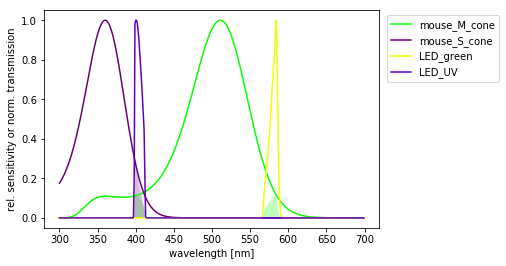

In [190]:
fh=plt.figure()
ax=fh.add_subplot(111)

for PR in PRs:
    if len(PR["spect"]) > 0:
        plt.plot(x_wavelen_nm, PR["spect"], 
                 color=scl.wavelength_to_rgb(PR["peak_nm"]), label=PR["name"])
        
for LED in LEDs:        
    if len(LED["spect"]) > 0:    
        colLED = scl.wavelength_to_rgb(LED["peak_nm"])
        plt.plot(x_wavelen_nm, LED["spect"], color=colLED, label="LED_" +LED["name"])
        for effect in LED["effect_on_PR"]:
            for PR in PRs:
                if PR["name"] == effect["PR_name"]:
                    colPR = scl.wavelength_to_rgb(PR["peak_nm"])
            plt.fill(x_wavelen_nm, effect["spect"], facecolor=colPR, alpha=0.25)    

ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("rel. sensitivity or norm. transmission") 
 
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

# Print co-excitation values for all LED/filter and photoreceptor combinations
#
print("Relative co-excitation:")
for LED in LEDs:        
    if len(LED["spect"]) > 0:    
        for effect in LED["effect_on_PR"]:
            print("{0:6.1f}% of {1} by {2}"
                  .format(effect["rel_exc"]*100, effect["PR_name"], LED["name"]))    

### Calculate photo-isomerization rates 

... for all LED/filter and photoreceptor combinations


In [191]:
for iLED, LED in enumerate(LEDs):
    # Convert energy flux from [nW] (=readout of photometer, in [nW]) into [eV/s]
    #
    LED["pow_eflux"] = LED["pow_meas_nW"] *1E-9 *eV_per_J

    # Calculate the wavelength-dependent photon energy `Q` in [eV]
    #
    LED["pow_Q"]     = c *h /(LED["peak_nm"] *1E-9)

    # Divide energy flux by the photon energy to get the photon flux `phi`[photons/s] 
    # and then photon flux density `E` [photons/s /µm^2]
    #
    LED["pow_phi"]   = LED["pow_eflux"] /LED["pow_Q"]
    LED["pow_E"]     = LED["pow_phi"] /A_detect_um2
    
    # Calculate per photoreceptor ...
    #
    for effect in LED["effect_on_PR"]:
        for iPR, PR in enumerate(PRs):
            if PR["name"] == effect["PR_name"]:
                # ... photon flux per photoreceptor `photon_rate` in [photons/s]
                #
                A_collect = PR["collecArea_um2"]
                effect["photon_rate"]   = LED["pow_E"] *A_collect
                
                # ... photoisomerizations [P*/photoreceptor /s]
                #
                effect["photoiso_rate"] = effect["photon_rate"] *effect["rel_exc"]
                if (iLED == 0) and (iPR == 0): 
                    print("Range of photoisomerization rates:")
                print("{0:5.1f} .. {1:5.1f} 10^3 photons/s in {2} for {3}"
                      .format(effect["photoiso_rate"][0]/1000.0, 
                              effect["photoiso_rate"][-1]/1000.0, PR["name"], LED["name"]))

Range of photoisomerization rates:
  0.0 ..  23.1 10^3 photons/s in mouse_M_cone for green
  0.0 ..   0.0 10^3 photons/s in mouse_S_cone for green
  0.0 ..  11.4 10^3 photons/s in mouse_M_cone for UV
  0.0 ..  20.0 10^3 photons/s in mouse_S_cone for UV


Plot photoisomerization rates for each LED/filter vs. photoreceptor combination and save these results to a text file.

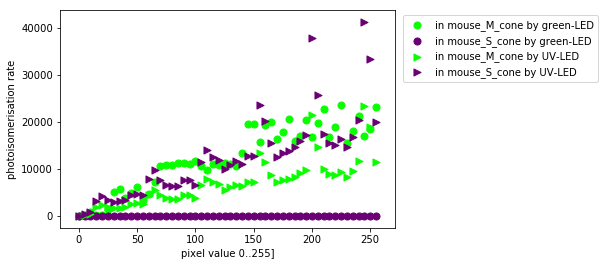

In [192]:
markers = ["o", ">", "<", "#"]
results = []
headStr = ""

fh=plt.figure()
ax=fh.add_subplot(111)
# Plot results
#
for iLED, LED in enumerate(LEDs):
    for iEffect, effect in enumerate(LED["effect_on_PR"]):
        for PR in PRs:
            if PR["name"] == effect["PR_name"]:
                if len(PR["spect"]) > 0:
                    colPR = scl.wavelength_to_rgb(PR["peak_nm"])
                    plt.scatter(LED["levels"], effect["photoiso_rate"], color=colPR, 
                                label="in " +PR["name"] +" by " +LED["name"] +"-LED",
                                marker=markers[iLED], s=50)
                    if (iLED == 0) and (iEffect == 0):
                        results.append(LED["levels"])
                        headStr += "levels" +"\t"
                    results.append(effect["photoiso_rate"])
                    headStr += PR["name"] +"_" +LED["name"] +"\t"


ax.set_xlabel("pixel value 0..255]")
ax.set_ylabel("photoisomerisation rate")

plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

# Save results to a text file
#
with open(pathData +calFileName +"Result.txt",'wb') as f:
     for i, row in enumerate(results):
        if i==0:
            np.savetxt(f, np.transpose(results[i]),header=headStr, newline=txtFileNewLineStr)
        else:
            np.savetxt(f, np.transpose(results[i]), newline=txtFileNewLineStr)

# Calculate gamma correction curve


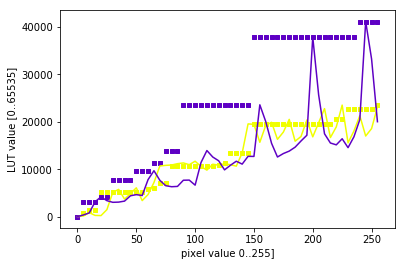

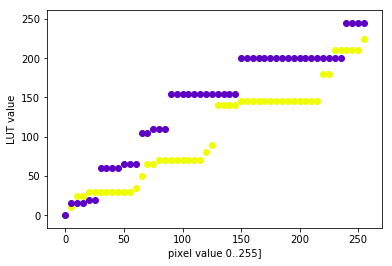

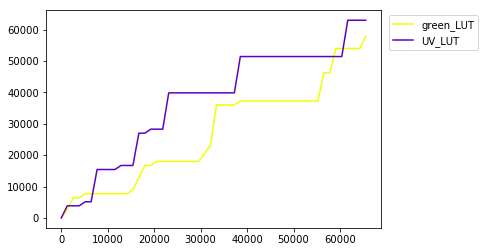

In [193]:
# Calculate linearized look-up tables
#
cases   = [LEDs[0]["name"] +PRs[0]["name"], # green for M-cones
           LEDs[1]["name"] +PRs[1]["name"]] # UV for S-cones
markers = ["s", "."]

for iLED, LED in enumerate(LEDs):
    for iEffect, effect in enumerate(LED["effect_on_PR"]):
        if LED["name"]+effect["PR_name"] in cases:
        
            colLED   = scl.wavelength_to_rgb(LED["peak_nm"])
        
            LUT      = np.copy(LED["levels"])
            rate     = np.copy(effect["photoiso_rate"])
            line     = [min(rate) +i/len(rate)*max(rate) for i in range(len(rate))]
            rate_lin = np.copy(rate)

            for iLev in range(len(LED["levels"])):
                iCorrLev       = np.where(rate>=line[iLev])[0][0]
                LUT[iLev]      = LED["levels"][iCorrLev]
                rate_lin[iLev] = rate[iCorrLev]

            levels_interp = np.array([i for i in range(256)])
            temp          = np.interp(levels_interp, LED["levels"], LUT)
            LUT_interp    = [int(v/255.0* (pow(2,16)-1)) for v in temp]
            levels_interp = [int(v/255.0* (pow(2,16)-1)) for v in levels_interp]
            
            LED["LUT"] = LUT
            LED["LUT_interp"] = LUT_interp
            LED["levels_interp"] = levels_interp
            
            fh1 = plt.figure(1)
            ax1 = fh1.add_subplot(111) 
            plt.scatter(LED["levels"], rate_lin, color=colLED, 
                        label=LED["name"] +"_lin", marker=markers[0], s=20)
            plt.plot(LED["levels"], rate, color=colLED, 
                     label=LED["name"] +"_before")
            
            fh2 = plt.figure(2)
            ax2 = fh2.add_subplot(111) 
            plt.scatter(LEDs[iLED]["levels"], LEDs[iLED]["LUT"], color=colLED,
                        label=LED["name"] +"_LUT")
            
            fh3 = plt.figure(3)
            ax3 = fh3.add_subplot(111) 
            plt.plot(LED["levels_interp"], LED["LUT_interp"], color=colLED,
                     label=LED["name"] +"_LUT")
                      
ax1.set_xlabel("pixel value 0..255]")
ax1.set_ylabel("photoisomerisation rate")            
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")    

ax2.set_xlabel("pixel value 0..255]")
ax2.set_ylabel("LUT value")                     
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left") 

ax1.set_xlabel("pixel value 0..255]")
ax1.set_ylabel("LUT value [0..65535]")            
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left") 

# Write gamma table for QDSpy
#
results = []
iCol    = 0

for iCol, LEDName in enumerate(gammaLEDOrder):
    for iLED, LED in enumerate(LEDs):
        if len(LEDName) == 0:
            results.append([int((v+1) *256 -1) for v in range(256)])
            break
        elif LED["name"] == LEDName:
            results.append(LED["LUT_interp"])
            break

np.savetxt(pathData +gammaFileName, np.transpose(results), fmt='%d', delimiter=', ',
           newline=txtFileNewLineStr)